## Hierarchical Bayesian analysis of the 2019-2020 NHL season (until it got canceled)

---

I am sad and I miss hockey, so I decided to build a simple hierarchical Bayesian model for the 2019-2020 NHL season. Since this model is fully probabilistic, I will be able to assess the offensive and defensive ability of teams. Furthermore, I can draw samples from the posterior distribution to simulate entire seasons, and the post-season, to see who is the true Cup champ.

This work is based in large part on [Baio and Blangiardo](https://discovery.ucl.ac.uk/id/eprint/16040/1/16040.pdf), [Daniel Weitzenfeld's great write-up](https://danielweitzenfeld.github.io/passtheroc/blog/2014/10/28/bayes-premier-league/), and a [nice application of this type of modeling to Rugby from the pymc3 docs](https://docs.pymc.io/notebooks/rugby_analytics.html).

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import pymc3 as pm
import theano.tensor as tt
import corner

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})

### Get the data

---

I will use pandas to scrape the 2019-2020 NHL season schedule and results from  [www.hockey-reference.com](https://www.hockey-reference.com/leagues/NHL_2020_games.html). Note that I will only get the results of every game played up to COVID-19 season suspension, but I will also have the schedule so I can simulate the rest of the season as well.

In [2]:
url = "http://www.hockey-reference.com/leagues/NHL_2020_games.html"
df = pd.read_html(url, parse_dates=True, attrs = {'id': 'games'},
                  header=0, index_col=0)[0]

In [3]:
df.head()

,Visitor,G,Home,G.1,Unnamed: 5,Att.,LOG,Notes
Date,,,,,,,,
2019-10-02,Vancouver Canucks,2.0,Edmonton Oilers,3.0,NaN,18347.0,2:23,NaN
2019-10-02,Washington Capitals,3.0,St. Louis Blues,2.0,OT,18096.0,2:32,NaN
2019-10-02,Ottawa Senators,3.0,Toronto Maple Leafs,5.0,NaN,19612.0,2:36,NaN
2019-10-02,San Jose Sharks,1.0,Vegas Golden Knights,4.0,NaN,18588.0,2:44,NaN
2019-10-03,Arizona Coyotes,1.0,Anaheim Ducks,2.0,NaN,17174.0,2:25,NaN


Looks like I have some data cleaning to do. For this modeling, we do not care about the attendance, length of the game (LOG), nor the Notes column, which is just empty. We can drop those.

In [4]:
df.drop(columns=["Att.", "LOG", "Notes"], inplace=True)

I also want to rename the columns to be a bit more informative.

In [5]:
df.head()

,Visitor,G,Home,G.1,Unnamed: 5
Date,,,,,
2019-10-02,Vancouver Canucks,2.0,Edmonton Oilers,3.0,NaN
2019-10-02,Washington Capitals,3.0,St. Louis Blues,2.0,OT
2019-10-02,Ottawa Senators,3.0,Toronto Maple Leafs,5.0,NaN
2019-10-02,San Jose Sharks,1.0,Vegas Golden Knights,4.0,NaN
2019-10-03,Arizona Coyotes,1.0,Anaheim Ducks,2.0,NaN


In [6]:
df.columns = ["awayTeam", "awayGoals", "homeTeam", "homeGoals", "Extra"]

# Fill in NaN with Reg for Regulation in the column that indicates whether
# or not a game went into OT/SO
df["Extra"].fillna("Reg", inplace=True)

Before I drop it, I want to use the Extra column to estimate the empirical probability that a game ends in a shootout, given OT. I will use this value later to help simulate games. I will not calculate this on a team-by-team basis just to keep it simple, but that change could improve the model in future iterations.

In [7]:
counts = df["Extra"].value_counts()
probSO = counts["SO"]/(counts["OT"] + counts["SO"])
print("Empirical probability of a team going to a SO, given OT: %lf" % probSO)

Empirical probability of a team going to a SO, given OT: 0.344000


In [8]:
df.tail()

,awayTeam,awayGoals,homeTeam,homeGoals,Extra
Date,,,,,
2020-04-04,Chicago Blackhawks,NaN,New York Rangers,NaN,Reg
2020-04-04,Pittsburgh Penguins,NaN,Ottawa Senators,NaN,Reg
2020-04-04,Anaheim Ducks,NaN,San Jose Sharks,NaN,Reg
2020-04-04,Montreal Canadiens,NaN,Toronto Maple Leafs,NaN,Reg
2020-04-04,Vegas Golden Knights,NaN,Vancouver Canucks,NaN,Reg


Now let's transforms team names into their initials, e.g. transform St. Louis Blues to STL, as that will make things a bit easier down the road. Then, I want to add columns to indicate who is the away team, who is the home team, and a unique id for each team for bookkeeping.

To map the names to their initials, I will make a simple mapping dictionary to apply to the Visitor and Home columns.

In [9]:
# Dictionary of NHL team names and abbreviations
conv = {'Anaheim Ducks' : 'ANA',
        'Arizona Coyotes' : 'ARI', 
        'Boston Bruins' : 'BOS', 
        'Buffalo Sabres' : 'BUF',
        'Calgary Flames' : 'CGY', 
        'Carolina Hurricanes' : 'CAR', 
        'Chicago Blackhawks' : 'CHI',
        'Colorado Avalanche' : 'COL', 
        'Columbus Blue Jackets' : 'CBJ', 
        'Dallas Stars' : 'DAL',
        'Detroit Red Wings' : 'DET', 
        'Edmonton Oilers'  : 'EDM',
        'Florida Panthers' : 'FLA',
        'Los Angeles Kings' : 'LAK',
        'Minnesota Wild' : 'MIN', 
        'Montreal Canadiens' : 'MTL',
        'Nashville Predators' : 'NSH', 
        'New Jersey Devils' : 'NJD',
        'New York Islanders' : 'NYI',
        'New York Rangers' : 'NYR', 
        'Ottawa Senators' : 'OTT',
        'Philadelphia Flyers' : 'PHI',
        'Pittsburgh Penguins' : 'PIT', 
        'San Jose Sharks' : 'SJS', 
        'St. Louis Blues' : 'STL',
        'Tampa Bay Lightning' : 'TBL', 
        'Toronto Maple Leafs' : 'TOR',
        'Vancouver Canucks' : 'VAN',
        'Vegas Golden Knights' : 'VGK',
        'Washington Capitals' : 'WSH',
        'Winnipeg Jets' : 'WPG'}
    
# Map the names
df["awayTeam"] = df["awayTeam"].map(conv)
df["homeTeam"] = df["homeTeam"].map(conv)

In [10]:
df.head()

,awayTeam,awayGoals,homeTeam,homeGoals,Extra
Date,,,,,
2019-10-02,VAN,2.0,EDM,3.0,Reg
2019-10-02,WSH,3.0,STL,2.0,OT
2019-10-02,OTT,3.0,TOR,5.0,Reg
2019-10-02,SJS,1.0,VGK,4.0,Reg
2019-10-03,ARI,1.0,ANA,2.0,Reg


These games, sadly, have not been played, so I am going to drop them as well.

In [11]:
# End of season hasn't happened :(
df.tail()

,awayTeam,awayGoals,homeTeam,homeGoals,Extra
Date,,,,,
2020-04-04,CHI,NaN,NYR,NaN,Reg
2020-04-04,PIT,NaN,OTT,NaN,Reg
2020-04-04,ANA,NaN,SJS,NaN,Reg
2020-04-04,MTL,NaN,TOR,NaN,Reg
2020-04-04,VGK,NaN,VAN,NaN,Reg


In [12]:
# First save the season schedule into a separate df
schedule = df[["homeTeam", "awayTeam"]].copy()

# Then drop all rows with NaN, that is, those without scores
df.dropna(inplace=True)

Now I will uniquely label each team. I first build a dummy pandas dataframe to map team abbreviations to a unique index, then I perform a series of joins using [pandas's merge method](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.merge.html) to label both the home and away teams. For this array, I will also figure out how many games each team has played.

In [13]:
allTeams = df["homeTeam"].unique()
teams = pd.DataFrame(allTeams, columns=['name'])
teams['ind'] = teams.index

# Figure out name of home team to help identify unique games
def calcGames(df, name):
    return (df['homeTeam'] == name).sum() + (df['awayTeam'].values == name).sum()

teams['gamesPlayed'] = teams.apply(lambda x : calcGames(df, x["name"]), axis=1)

In [14]:
teams.head()

,name,ind,gamesPlayed
0,EDM,0,71
1,STL,1,71
2,TOR,2,70
3,VGK,3,71
4,ANA,4,71


In [15]:
df = pd.merge(df, teams, left_on='homeTeam', right_on='name', how='left')
df = df.rename(columns={'ind': 'homeIndex'}).drop(columns=["name", "gamesPlayed"])
df = pd.merge(df, teams, left_on = 'awayTeam', right_on = 'name', how = 'left')
df = df.rename(columns = {'ind': 'awayIndex'}).drop(columns=["name", "gamesPlayed"])

In [16]:
df.head()

,awayTeam,awayGoals,homeTeam,homeGoals,Extra,homeIndex,awayIndex
0,VAN,2.0,EDM,3.0,Reg,0,24
1,WSH,3.0,STL,2.0,OT,1,22
2,OTT,3.0,TOR,5.0,Reg,2,21
3,SJS,1.0,VGK,4.0,Reg,3,16
4,ARI,1.0,ANA,2.0,Reg,4,17


Our season data is looking pretty good. 

For the model criticism and examination we'll perform later, I first want to compute things like points percentage (what fraction of points did a team earn in all their games), games played, goals for per game, and goals against per game. I expect these quantities to obviously correlate with defense and attack strengths. Note that for games that end in a SO, I follow the NHL convention and count it as a goal scored by the winning team.

In [17]:
# Felt lazy so I typed the values in by-hand from https://www.nhl.com/standings
points = {'ANA' : 67,
          'ARI' : 74,
          'BOS' : 100,
          'BUF' : 68,
          'CGY' : 79, 
          'CAR' : 81, 
          'CHI' : 72,
          'COL' : 92, 
          'CBJ' : 81, 
          'DAL' : 82,
          'DET' : 39, 
          'EDM' : 83,
          'FLA' : 78,
          'LAK' : 64,
          'MIN' : 77, 
          'MTL' : 71,
          'NSH' : 78, 
          'NJD' : 68,
          'NYI' : 80,
          'NYR' : 79, 
          'OTT' : 62,
          'PHI' : 89,
          'PIT' : 86, 
          'SJS' : 63, 
          'STL' : 94,
          'TBL' : 92, 
          'TOR' : 81,
          'VAN' : 78,
          'VGK' : 86,
          'WSH' : 90,
          'WPG' : 80}

# Compute points percentage for each team
pointsArr = np.empty(len(teams))
for ii, team in enumerate(teams["name"]):
    pointsArr[ii] = points[team]/(int(teams[teams.name == team]["gamesPlayed"].values) * 2)
    
# First I'll create groups for away and home teams
awayGroup = df.groupby("awayTeam")
homeGroup = df.groupby("homeTeam")

# Calculate goals for per game
scoredTeam = awayGroup.sum()["awayGoals"] + homeGroup.sum()["homeGoals"]
scored = teams.join(scoredTeam.to_frame(), on="name", how="left")
scored.columns = ["name", "ind", "gamesPlayed", "goalsFor"]
goalsFor = scored["goalsFor"].values/scored["gamesPlayed"].values

# Calculate goals against per game
concededTeam = awayGroup.sum()["homeGoals"] + homeGroup.sum()["awayGoals"]
conceded = teams.join(concededTeam.to_frame(), on="name", how="left")
conceded.columns = ["name", "ind", "gamesPlayed", "goalsAgainst"]
goalsAgainst = (conceded["goalsAgainst"]/conceded["gamesPlayed"]).values

Our data is now ready! Below, I will describe the mathematical model we use that was developed by [Baio and Blangiardo](https://discovery.ucl.ac.uk/id/eprint/16040/1/16040.pdf) and extended by [Daniel Weitzenfeld](https://danielweitzenfeld.github.io/passtheroc/blog/2014/10/28/bayes-premier-league/).

### Define the mathematical model

---

Here I describe how we will mathematically model the games. From [Baio and Blangiardo](https://discovery.ucl.ac.uk/id/eprint/16040/1/16040.pdf), we will model the number of observed goals in the gth game for the jth team as a Poisson model:

$y_{g,j} | \theta_{g,j} = \mathrm{Poisson}(\theta_{g,j})$

where $\theta_{g}=(\theta_{g,h}, \theta_{g,a})$ represent "the scoring intensity" for the given team in the given game. Note, j = h indicates the home team whereas j = a indicates the away team. 

[Baio and Blangiardo](https://discovery.ucl.ac.uk/id/eprint/16040/1/16040.pdf) and [Daniel Weitzenfeld](https://danielweitzenfeld.github.io/passtheroc/blog/2014/10/28/bayes-premier-league/) use a log-linear model for $\theta$ that is decomposed into latent, or unobserved, terms for the home ice advantage (home), a team's attacking strength (att), a team's defensive strength (def), and an intercept term (intercept) that Daniel Weitzenfeld uses to capture the the mean number of goals scored by a team. Therefore, the home team's attacking ability, $att_{h(g)}$, is pitted against the away team's defensive ability, $def_{a(g)}$ where $h(g)$ and $a(g)$ identify which teams are the home and away team in the gth game. A strong attacking team will have a large $att$, whereas a good defensive team will have a large negative $def$. 

Note that to maintain model identifiability, we follow [Baio and Blangiardo](https://discovery.ucl.ac.uk/id/eprint/16040/1/16040.pdf) to enforce a "sum-to-zero" constraint on both att and def. Below, I will show how to do this with pymc3. This constraint, coupled with the fact that we are using a linear model, will allow us to directly compare the team abilities we will infer.

Putting this all together, our model for the home and away log scoring intensity is as follows:

$\log{\theta_{h,g}} = intercept + home + att_{h(g)} + def_{a(g)}$ for the home team and 

$\log{\theta_{a,g}} = intercept + att_{a(g)} + def_{h(g)}$ for the away team.

Note how the team indicies are reversed in the two equations based on our assumption of a log-linear model for how the team stength parameters interact. The scoring intensity of the away team, $\log{\theta_{a,g}}$, for example, depends on the sum of the away team's attacking strength, $att_{a(g)}$, home team's defensive ability, $def_{h(g)}$, and the typical amount of goals scored by a team, the intercept.

### Define the (hyper)priors

---

All Bayesian models require prior and hyperprior distributions for the model parameters and hyperparameters, respectively. I adopt the priors used by both [Baio and Blangiardo](https://discovery.ucl.ac.uk/id/eprint/16040/1/16040.pdf) and [Daniel Weitzenfeld](https://danielweitzenfeld.github.io/passtheroc/blog/2014/10/28/bayes-premier-league/) and I list them below for completeness. 

Note that Normal distributions in pymc3 are initialized with a mean, $\mu$, and a precision, $\tau$, instead of the standard mean and variance, $\sigma^2$. Therefore, a Normal distribution with a small $\tau = 0.0001$ approximates a Uniform distribution with effectively infinite bounds. Also, here I will use $t$ to index an arbitrary team.

The flat priors for the home and intercept terms are given by

$home \sim \mathrm{Normal}(0,0 .0001)$
 
$intercept \sim \mathrm{Normal}(0, 0.0001)$

The hyperpriors for each team's attacking and defensive strengths are

$att_t \sim \mathrm{Normal}(0, \tau_{att})$

$def_t \sim \mathrm{Normal}(0, \tau_{def})$

where we neglect the mean terms because of our "sum-to-zero" constraint. The hyperpriors on the precisions are given by

$\tau_{att} \sim \mathrm{Gamma}(0.1, 0.1)$

$\tau_{def} \sim \mathrm{Gamma}(0.1, 0.1)$

We assume that each team's attacking and defensive strengths are assumed to be drawn the same parent distribution and are hence exchangeable.

### Build the PyMC3 model

---

Now let us use PyMC3 to build the model using probabilistic programming. After I define the model, I can draw samples from the posterior distribution.

First, I will define a few useful quantities to make coding up the model easier.

In [18]:
# Observed goals
observedHomeGoals = df["homeGoals"].values
observedAwayGoals = df["awayGoals"].values

# Inidices for home and away teams
homeTeam = df["homeIndex"].values
awayTeam = df["awayIndex"].values

# Number of teams, games
numTeams = len(list(set(df["homeIndex"])))
numGames = len(df)

In [19]:
with pm.Model() as model:

    # Home, intercept priors
    home = pm.Normal('home', mu=0.0, tau=0.0001)
    intercept = pm.Normal('intercept', mu=0.0, tau=0.0001)
    
    # Hyperpriors on taus
    tauAtt = pm.Gamma("tauAtt", alpha=0.1, beta=0.1)
    tauDef = pm.Gamma("tauDef", alpha=0.1, beta=0.1)
    
    # Attacking, defensive strength for each team
    attsStar = pm.Normal("attsStar", mu=0.0, tau=tauAtt, shape=numTeams)
    defsStar = pm.Normal("defsStar", mu=0.0, tau=tauDef, shape=numTeams)

    # Impose "sum-to-zero" constraint
    atts = pm.Deterministic('atts', attsStar - tt.mean(attsStar))
    defs = pm.Deterministic('defs', defsStar - tt.mean(defsStar))
    
    # Compute theta for the home and away teams
    homeTheta = tt.exp(intercept + home + atts[homeTeam] + defs[awayTeam])
    awayTheta = tt.exp(intercept + atts[awayTeam] + defs[homeTeam])

    # Assume a Poisson likelihood for the observed goals
    homeGoals = pm.Poisson('homeGoals', mu=homeTheta, observed=observedHomeGoals)
    awayGoals = pm.Poisson('awayGoals', mu=awayTheta, observed=observedAwayGoals)

### Sample the posterior distribution and examine MCMC convergence

---

With this probabilistic model in hand, let's sample from the posterior distribution. Once the sampling is completed, I will examine numerous diagnostic statistics, including the Gelman-Rubin statistic, and visually examine the joint and marginal posterior distribution to confirm convergence.

In [20]:
with model:
    trace = pm.sample(draws=10000, tune=100, progressbar=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [defsStar, attsStar, tauDef, tauAtt, intercept, home]
Sampling 2 chains, 0 divergences: 100%|██████████| 20200/20200 [02:23<00:00, 140.49draws/s]
The acceptance probability does not match the target. It is 0.9354878697926082, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9400624871749638, but should be close to 0.8. Try to increase the number of tuning steps.


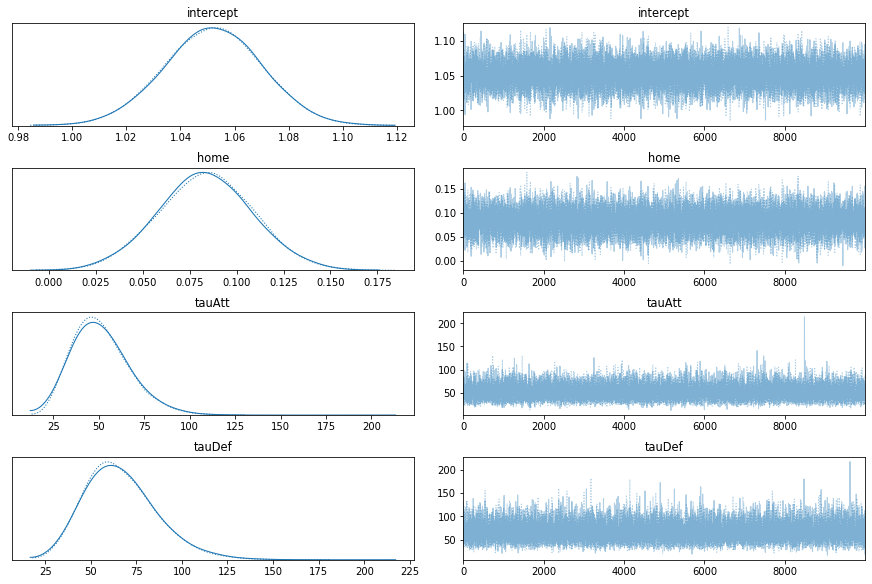

In [21]:
pm.traceplot(trace, var_names=['intercept', 'home', 'tauAtt', 'tauDef']);

In [22]:
pm.summary(trace, var_names=['intercept', 'home', 'tauAtt', 'tauDef'])

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
intercept,1.052,0.018,1.018,1.086,0.000,0.000,22564.0,22564.0,22570.0,14752.0,1.0
home,0.084,0.025,0.037,0.131,0.000,0.000,22271.0,19766.0,22314.0,12882.0,1.0
tauAtt,51.474,15.418,24.253,80.334,0.101,0.075,23433.0,21369.0,23419.0,15972.0,1.0
tauDef,66.781,19.505,32.411,102.713,0.127,0.094,23429.0,21551.0,23417.0,16941.0,1.0


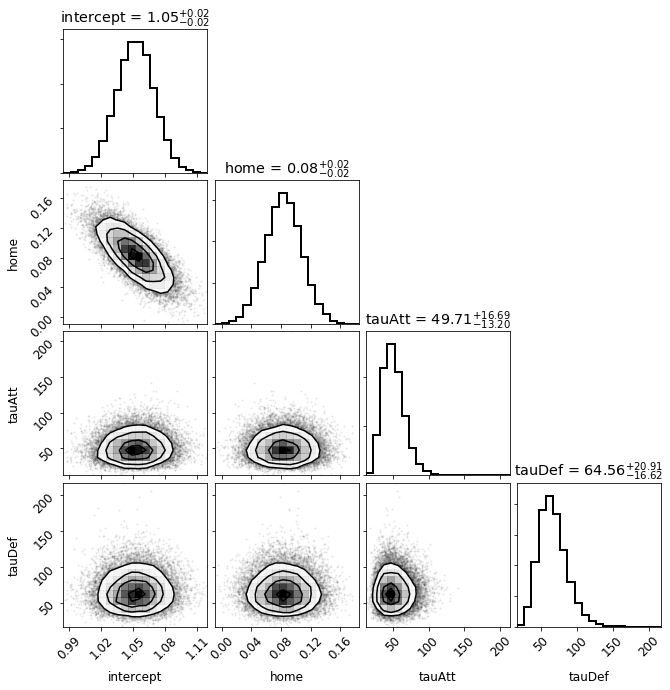

In [23]:
varNames = ['intercept', 'home', 'tauAtt', 'tauDef']

samples = np.empty((20000, 4))
for ii, var in enumerate(varNames):
    samples[:,ii] = trace[var]
    
_ = corner.corner(samples, labels=varNames, lw=2, hist_kwargs={"lw" : 2}, show_titles=True)

It appears that the only significant correlations are between the intercept term and the home ice advantage term. This correlation makes sense, however, given that the intercept effectively quantifies the typical number of log goals (typical goals = exp(intercept)) scored by a team. If the average team scores more goals, we would expect the home ice advantage to weaken.

Now let's consider the Bayesian fraction of mission information (BFMI), the Gelman-Rubin statistic, and the marginal energy distribution of the MCMC. I won't go into the mathetmatics here, but we want the BFMI and Gelman-Rubin statistics to be about 1 for a converged chain. Furthermore, if the distribution of marginal energy and the energy transition are similar, the chain is likely converged.

In [24]:
# Estimate the maximum Bayesian fraction of missing information (BFMI) and
# Gelman-Rubin statistic
bfmi = np.max(pm.stats.bfmi(trace))
maxGR = max(np.max(gr) for gr in pm.stats.rhat(trace).values()).values

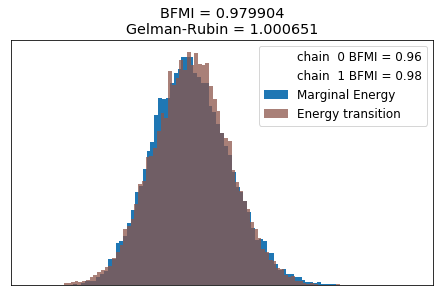

In [25]:
ax = pm.energyplot(trace, kind="histogram", legend=True, figsize=(6, 4))
ax.set_title("BFMI = %lf\nGelman-Rubin = %lf" % (bfmi, maxGR));

It looks like our model has converged! 

### Explore model implications

---

Now that I convinced myself that we drew enough valid samples from the posterior distribution, I can examine the inferred posterior distributions for our model latent variables like a team's offensive and defensive strengths.

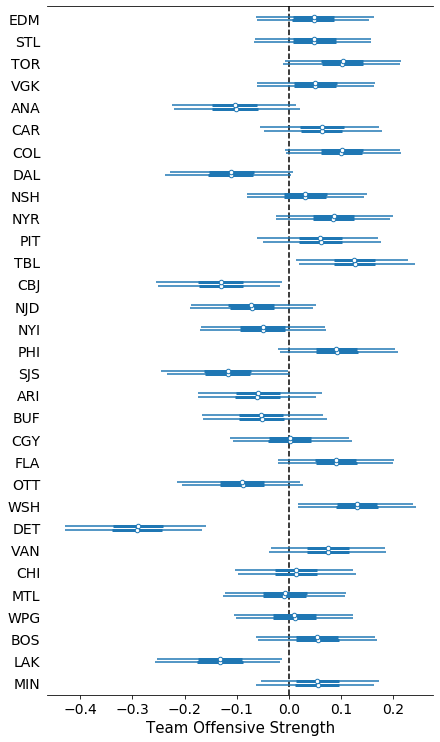

In [26]:
ax = pm.forestplot(trace, var_names=['atts'])
ax[0].set_yticklabels(teams.iloc[::-1]['name'].tolist())
ax[0].axvline(0, color="k", zorder=0, ls="--")
ax[0].set_xlabel('Team Offensive Strength', fontsize=15)
ax[0].set_title("");

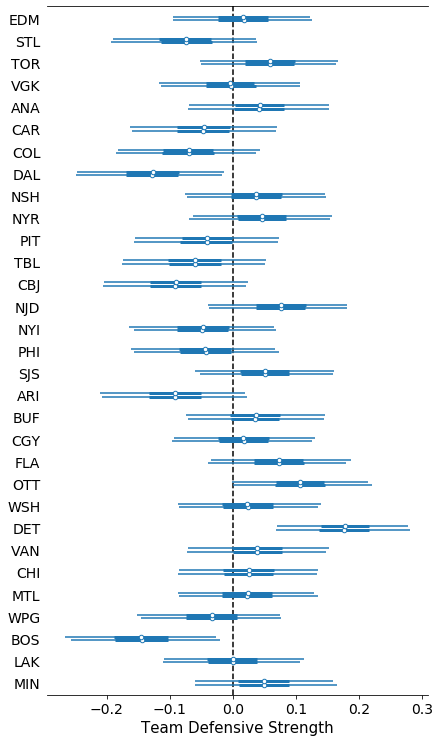

In [27]:
ax = pm.forestplot(trace, var_names=['defs'])
ax[0].axvline(0, color="k", zorder=0, ls="--")
ax[0].set_yticklabels(teams.iloc[::-1]['name'].tolist())
ax[0].set_xlabel('Team Defensive Strength', fontsize=15)
ax[0].set_title("");

Now let's plot these same quantities, but ranking teams from worst (Detroit) to best. Remember: a team wants to have a large attack strength (score more goals!) and a large *negative* defense strength (make the other team score fewer goals!).

In [28]:
# Calculate median, 68% CI for atts, defs for each team
medAtts = np.median(trace["atts"], axis=0)
medDefs = np.median(trace["defs"], axis=0)

defsCI = pm.stats.hpd(trace["defs"], credible_interval=0.68)
attsCI = pm.stats.hpd(trace["atts"], credible_interval=0.68)

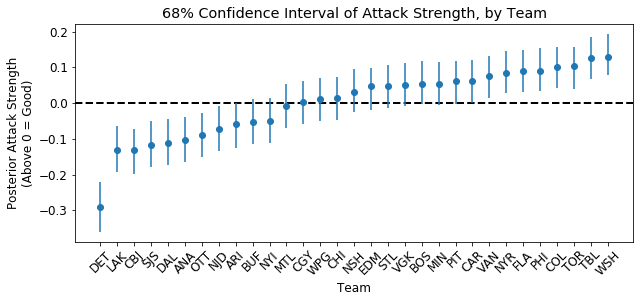

In [29]:
# Plot ordered attacking strength
fig, ax = plt.subplots(figsize=(10,4))

# Order values by worst to best attacking
inds = np.argsort(medAtts)

x = np.arange(len(medAtts))
ax.errorbar(x, medAtts[inds], yerr=[medAtts[inds] - attsCI[inds,0], attsCI[inds,1] - medAtts[inds]], 
            fmt='o')

ax.axhline(0, lw=2, ls="--", color="k", zorder=0)
ax.set_title('68% Confidence Interval of Attack Strength, by Team')
ax.set_xlabel('Team')
ax.set_ylabel('Posterior Attack Strength\n(Above 0 = Good)')
_ = ax.set_xticks(x)
_ = ax.set_xticklabels(teams["name"].values[inds], rotation=45)

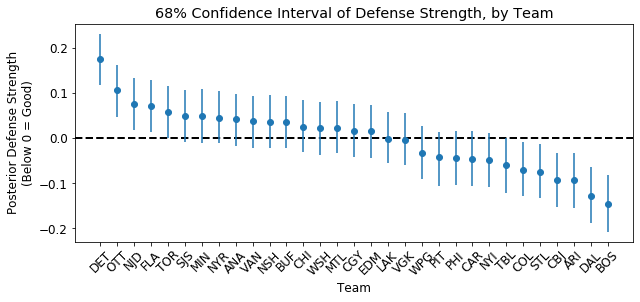

In [30]:
# Plot ordered defense strength
fig, ax = plt.subplots(figsize=(10,4))

# Order values by worst to best attacking
inds = np.argsort(medDefs)[::-1]

x = np.arange(len(medDefs))
ax.errorbar(x, medDefs[inds], yerr=[medDefs[inds] - defsCI[inds,0], defsCI[inds,1] - medDefs[inds]], 
            fmt='o')

ax.axhline(0, lw=2, ls="--", color="k", zorder=0)
ax.set_title('68% Confidence Interval of Defense Strength, by Team')
ax.set_xlabel('Team')
ax.set_ylabel('Posterior Defense Strength\n(Below 0 = Good)')
_ = ax.set_xticks(x)
_ = ax.set_xticklabels(teams["name"].values[inds], rotation=45)

Below, I'll see how teams' points percentage varies as a function of attack and defense strengths. I expect that teams with a higher points percentage, e.g. BOS and STL, will have large attack and large negative defense strengths and for the converse to be true for bad teams like DET.

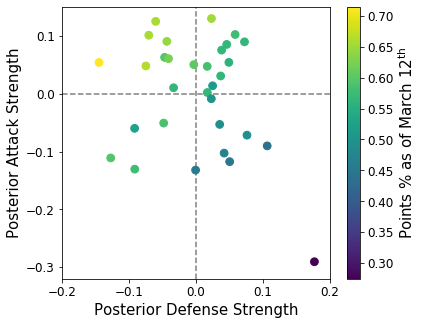

In [37]:
fig, ax = plt.subplots(figsize=(6,5))

im = ax.scatter(medDefs, medAtts, c=pointsArr, s=60, zorder=1)
ax.axhline(0, lw=1.5, ls="--", color="grey", zorder=0)
ax.axvline(0, lw=1.5, ls="--", color="grey", zorder=0)

cbar = fig.colorbar(im)
cbar.set_label(r"Points % as of March 12$^{\mathrm{th}}$", fontsize=15)
ax.set_xlabel('Posterior Defense Strength', fontsize=15)
ax.set_ylabel('Posterior Attack Strength', fontsize=15)
ax.set_xlim(-0.2, 0.2);
ax.set_ylim(-0.32, 0.15);

Above I plotted each team's posterior attack strength vs. the posterior defense strength. Each point represents a team and the color encodes the team's season points total as of March 12th, 2020 when the NHL season was officially suspended. Clearly, there is a gradient in total points (color) that follows a reasonable trend: teams with strong attacks (large attack strength) and strong defense (large negative defense strength) tend to perform bettern and accumulate more points. BOS, arguably the best team in the NHL in 2019-2020, is located in the strong attack/defense quandrant and is appropriately colored yellow for 100 points. DET (purple dot in the bad quadrant), on the other hand, is far-and-away the worst team in the NHL and our model captures that.

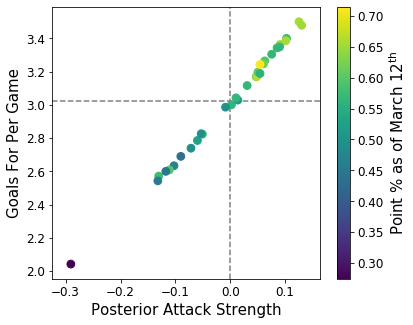

In [32]:
fig, ax = plt.subplots(figsize=(6,5))

im = ax.scatter(medAtts, goalsFor, c=pointsArr, s=60, zorder=1)
ax.axhline(np.mean(goalsFor), lw=1.5, ls="--", color="grey", zorder=0)
ax.axvline(0, lw=1.5, ls="--", color="grey", zorder=0)

cbar = fig.colorbar(im)
cbar.set_label(r"Point % as of March 12$^{\mathrm{th}}$", fontsize=15)
ax.set_xlabel('Posterior Attack Strength', fontsize=15)
ax.set_ylabel('Goals For Per Game', fontsize=15);

It looks like our posterior attack strength parameter accurately captures offense strength as there is a tight correlation between the two. Generally, it appears the number of points a team earns increases with both posterior attack strength and goals for as we'd expect, but there is some scatter that is likely caused by the uncertainty in the posterior distributions.

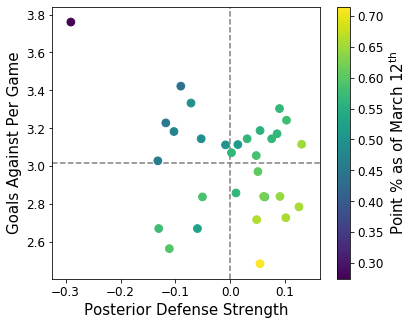

In [33]:
fig, ax = plt.subplots(figsize=(6,5))

im = ax.scatter(medAtts, goalsAgainst, c=pointsArr, s=60, zorder=1)
ax.axhline(np.mean(goalsAgainst), lw=1.5, ls="--", color="grey", zorder=0)
ax.axvline(0, lw=1.5, ls="--", color="grey", zorder=0)

cbar = fig.colorbar(im)
cbar.set_label(r"Point % as of March 12$^{\mathrm{th}}$", fontsize=15)
ax.set_xlabel('Posterior Defense Strength', fontsize=15)
ax.set_ylabel('Goals Against Per Game', fontsize=15);

Interestingly, the correlation between goals against and posterior defense strength is *much* weaker than what we saw above for attacking values. The correlation between points and a linear combination of goals against and posterior defense strength, i.e. the color gradient from the top left to the bottom right of the figure, appears much stronger. Perhaps there's more to defense than simply goals conceded. I think this makes sense in a game like hockey because a team can get shelled 50-15 in terms of shots but only lose 1-0 whereas a team can lose 3-0 but take more shots than the other team and dominate the play. Hockey is a non-linear game to say the least, but I think our model is doing pretty well given its simplicity.

### Simulating games (and the rest of the 2019-2020 season)

---

I have shown with fairly high confidence that the defending champions, the St. Louis Blues, are a much better offensive and defensive team than the Chicago Blackhawks. Also, Detroit is a bad team overall (other than Robby Fabbri and Dylan Larkin). Therefore, it appears that my model is realistically modeling the strengths and weaknesses of NHL teams given the games we have observed so far and our simplified model. Now we can turn to making some predictions using simulations.

My favorite aspect of probabilistic modeling is how I can draw samples from the posterior distribution to simulate games and reasonably account for model uncertainty. That is, I can estimate the likelihood that NHL Team A beats Team B at home. Moreover, I can estimate probability distributions for the score. Naturally, this can be extrapolated to simulating "Best-of-7" series and the playoffs more generally. For now, I will focus on simulating individual games and then the rest of the season to see how many points each team likely would have earned throughout a full 82 game season. Recall that above, I saved the entire season's schedule. We will use that below to simulate the rest of the season.

In [34]:
def simulateGame(trace, ind, homeTeam, awayTeam, teams, chain=0):
    """
    Simulate an NHL game where awayTeam plays at homeTeam and trace
    is a draw from the posterior distribution for model parameters,
    e.g. atts and defs. In this simplified model, if the game goes to
    OT, I say the game goes to a SO 34.4% of the team, the empirical
    fraction from this season's NHL results. If the game ends in either
    and OT or SO, I assign each team equal odds to win and randomly decide,
    assigning an extra goal to the winner.
    
    Parameters
    ----------
    trace : iterable
        Posterior distribution MCMC chain
    ind : int
        Index representing posterior draw
    homeTeam : str
        Name of the home team, like STL
    awayTeam : str
        Name of the away team, like CHI
    teams : pd.DataFrame
        pandas dataframe of teams that maps
        team name to a unique index
    chain : int (optional)
        Which chain to draw from. Defaults to 0.
    
    Returns
    -------
    homeGoals : int
        number of goals scored by the home team
    awayGoals : int
        number of goals scored by the away team
    homeWin : bool
        whether or not the hometeam won
    note : str
        indicates if the game finished in regulation (REG),
        overtime (OT), or a shooutout (SO).
    """
    
    # Extract posterior parameters
    home = trace.point(ind, chain=chain)["home"]
    intercept = trace.point(ind)["intercept"]
    homeAtt = trace.point(ind)["atts"][int(teams[teams["name"] == homeTeam]["ind"])]
    homeDef = trace.point(ind)["defs"][int(teams[teams["name"] == homeTeam]["ind"])]
    awayAtt = trace.point(ind)["atts"][int(teams[teams["name"] == awayTeam]["ind"])]
    awayDef = trace.point(ind)["defs"][int(teams[teams["name"] == awayTeam]["ind"])]
    
    # Compute home and away goals using log-linear model, draws for model parameters 
    # from posterior distribution. Recall - model goals as a draws from
    # conditionally-independent Poisson distribution: y | theta ~ Poisson(theta)
    homeTheta = np.exp(home + intercept + homeAtt + awayDef)
    awayTheta = np.exp(intercept + awayAtt + homeDef)
    homeGoals = np.random.poisson(homeTheta)
    awayGoals = np.random.poisson(awayTheta)
    
    # Figure out who wins
    note = "REG"
    if homeGoals > awayGoals:
        homeWin = True
    elif awayGoals > homeGoals:
        homeWin = False
    else:
        # Does the game go into a shootout?
        if np.random.uniform(low=0, high=1) < 0.344:
            note = "SO"
            # Randomly decided who wins
            if np.random.uniform(low=0, high=1) < 0.5:
                homeWin = True
                homeGoals += 1
            else:
                homeWin = False
                awayGoals += 1
        # No shootout, randomly decide who wins OT
        else:
            note = "OT"
            # Randomly decided who wins
            if np.random.uniform(low=0, high=1) < 0.5:
                homeWin = True
                homeGoals += 1
            else:
                homeWin = False
                awayGoals += 1
        
    return homeGoals, awayGoals, homeWin, note  

### Case Study: How likely is it that the St. Louis Blues sweep the season series against the Chicago Blackhawks, a team that has not won a game in the playoffs since 2016?

---

This season, the Blues swept the season series with Chicago, 4 wins to 0 losses, for the first time in franchise history. Using my model, I can estimate how often that would have occured. For this estimation, I'll simulate 2,500 4 games series where each team has 2 home games.

In [35]:
nTrials = 2500
nGames = 4

# numpy array to hold results
bluesRes = np.zeros((nTrials, nGames), dtype=int)

# random array of indicies to sample from
choices = np.arange(10000)

for ii in range(nTrials):
    
    # nGames game series
    for jj in range(nGames):
        
        # Set home, away team
        if jj < 2:
            homeTeam = "STL"
            awayTeam = "CHI"
        else:
            homeTeam = "CHI"
            awayTeam = "STL"
    
        # Draw random sample with replacement from one of 2 MCMC chains
        ind = np.random.choice(choices)
        chain = np.random.randint(2)

        # Simulate the game, save whether or not Blues won the game
        _, _, homeWin, _ = simulateGame(trace, ind, homeTeam, awayTeam, teams, chain=chain)
        if jj < 2:
            bluesRes[ii, jj] = int(homeWin)
        else:
            bluesRes[ii, jj] = int(not homeWin)

In [36]:
mask = bluesRes.all(axis=1)
print("STL sweeps the season series against CHI in %0.1lf %% of simulated seasons." % (np.mean(mask) * 100))

mask = (bluesRes.sum(axis=1) > 2)
print("STL wins the season series against CHI in %0.1lf %% of simulated seasons." % (np.mean(mask) * 100))

mask = (bluesRes.sum(axis=1) == 2)
print("STL ties the season series against CHI in %0.1lf %% of simulated seasons." % (np.mean(mask) * 100))

mask = (bluesRes.sum(axis=1) < 2)
print("CHI wins the season series against STL in %0.1lf %% of simulated seasons." % (np.mean(mask) * 100))

STL sweeps the season series against CHI in 9.8 % of simulated seasons.
STL wins the season series against CHI in 40.1 % of simulated seasons.
STL ties the season series against CHI in 38.6 % of simulated seasons.
CHI wins the season series against STL in 21.3 % of simulated seasons.


Awesome! It was of course unlikely for the Blues to sweep the regular season series against the Blackhawks since they were not *that* bad this year, but the Blues had a decent chance, about 1 in 10, and took it. Also, my model predicts that the Blues should win, or at least tie, the season series over 3/4s of the time.

### Simulating the rest of the 2019-2020 season

---